# Ikeda eddy damping

# Purpose
Investigate the implementation of the eddy damping 

# Methodology
Following the sectional eddy damping published in <cite data-cite="7505983/4AFVVGNT"></cite>.

![](ikeda_eddy_section_A.PNG)
<div class="cite2c-biblio"></div>

In [1]:
# %load imports.py
"""
These is the standard setup for the notebooks.
"""

%matplotlib inline
%load_ext autoreload
%autoreload 2

from jupyterthemes import jtplot
jtplot.style(theme='onedork', context='notebook', ticks=True, grid=False)

import pandas as pd
pd.options.display.max_rows = 999
pd.options.display.max_columns = 999
pd.set_option("display.max_columns", None)
import numpy as np
import os
import matplotlib.pyplot as plt
from collections import OrderedDict
#plt.style.use('paper')

#import data
import copy
from mdldb.run import Run

from sklearn.pipeline import Pipeline
from rolldecayestimators.transformers import CutTransformer, LowpassFilterDerivatorTransformer, ScaleFactorTransformer, OffsetTransformer
from rolldecayestimators.direct_estimator_cubic import EstimatorQuadraticB, EstimatorCubic
from rolldecayestimators.ikeda_estimator import IkedaQuadraticEstimator
import rolldecayestimators.equations as equations
import rolldecayestimators.lambdas as lambdas
from rolldecayestimators.substitute_dynamic_symbols import lambdify
import rolldecayestimators.symbols as symbols
import sympy as sp

from sympy.physics.vector.printing import vpprint, vlatex
from IPython.display import display, Math, Latex

from sklearn.metrics import r2_score
from src.data import database
from mdldb import tables
import shipflowmotionshelpers.shipflowmotionshelpers as helpers


Duplicate key in file WindowsPath('C:/Users/maa/.matplotlib/stylelib/paper.mplstyle'), line 461 ('figure.figsize   : 5, 3   ## figure size in inches')
Duplicate key in file WindowsPath('C:/Users/maa/.matplotlib/stylelib/paper.mplstyle'), line 462 ('figure.dpi       : 100        ## figure dots per inch')


In [2]:
from rolldecayestimators import ikeda_speed
#from rolldecayestimators.ikeda_naked import eddy_sections
from rolldecayestimators.ikeda_speed import eddy_sections

from rolldecayestimators import simplified_ikeda
import seaborn as sns

# Load digitalized ikeda results

In [3]:
import json

def load_digitalized(file_path:str):
    
    with open(file_path, mode='r') as file:
        j = json.load(file)
    
    df = pd.DataFrame()
    for dataset in j['datasetColl']:
        df_ = load_dataset(dataset=dataset)
        df = df.append(df_)
        
    return df

def load_dataset(dataset):
    
    name = dataset['name']
    
    xs = []
    ys = []
    for data in dataset['data']:
        x = float(data['value'][0])
        y = float(data['value'][1])
        xs.append(x)
        ys.append(y)
        
    df = pd.DataFrame()
    df['x'] = xs
    df['y'] = ys
    df['x'] = df['x'].astype(float)
    df['y'] = df['y'].astype(float)
    
    df['name'] = name
    
    return df

In [23]:
file_paths = {
'A': '../data/external/ikeda_eddy_section_A_phi_a.json',
'B': '../data/external/ikeda_eddy_section_B_phi_a.json',
'C': '../data/external/ikeda_eddy_section_C_phi_a.json',
'D': '../data/external/ikeda_eddy_section_D_phi_a.json',
}

df_paper = pd.DataFrame()
for model, file_path in file_paths.items():
    df_ = load_digitalized(file_path=file_path)
    df_['model']=model
    df_paper = df_paper.append(df_)

df_paper.rename(columns={
    'x':'phi_a',
    'y':'B_star_hat',
    'name':'w_hat',
    }, inplace=True)
df_paper['w_hat'] = df_paper['w_hat'].astype(float)
df_paper['phi_a'] = df_paper['phi_a'].round(decimals=2)

In [24]:
def B_W_B_F(row):
    mask = ((df_paper.model == row.model) & (df_paper.phi_a==0) & (df_paper.w_hat == row.w_hat))
    df_origo = df_paper.loc[mask]
    if len(df_origo)==0:
        return None
    elif len(df_origo)==1:
        origo = df_origo.iloc[0]
    else:
        raise ValueError('Too many...')
    
    B = origo['B_star_hat']
    return B

In [25]:
df_paper['B_W+B_F'] = df_paper.apply(func=B_W_B_F, axis=1)
df_paper['B_e_star_hat'] = df_paper['B_star_hat'] - df_paper['B_W+B_F']

In [26]:
df_paper

,phi_a,B_star_hat,w_hat,model,B_W+B_F,B_e_star_hat
0,0.00,0.003636,0.751,A,0.003636,0.000000
1,0.23,0.041169,0.751,A,0.003636,0.037534
0,-0.00,0.001391,0.507,A,0.001391,0.000000
1,0.24,0.029803,0.507,A,0.001391,0.028413
0,-0.00,0.003265,0.751,B,0.003265,0.000000
1,0.30,0.023966,0.751,B,0.003265,0.020700
0,-0.00,0.001111,0.536,B,0.001111,0.000000
1,0.30,0.014438,0.536,B,0.001111,0.013328
0,0.00,0.002115,0.751,C,0.002115,0.000000
1,0.27,0.008265,0.751,C,0.002115,0.006151


In [27]:
df = pd.read_csv('../data/external/ikeda_eddy._sections.csv', sep=';', index_col=0)
df.head()

,L,B,d,volume,H0,sigma,OG/d,R
No,,,,,,,,
A,0.8,0.280,0.112,0.02509,1.250,1.000,0.000,0.00
B,0.8,0.280,0.112,0.02501,1.250,0.997,0.000,0.01
C,0.8,0.280,0.112,0.02495,1.250,0.995,0.000,0.02
D,0.8,0.280,0.112,0.02475,1.250,0.988,0.000,0.03
E,0.8,0.024,0.070,0.00116,0.171,0.866,-1.753,NaN


# Model A

In [9]:
parameters = df.loc['A']

In [10]:
sigma = parameters.sigma
B_s = np.array([parameters.B])
T_s = parameters.d
S_s = sigma*B_s*T_s
a, a_1, a_3, sigma_s, H = ikeda_speed.calculate_sectional_lewis(B_s=B_s, T_s=T_s, S_s=S_s)

## Journee limits

In [11]:
H

array([1.25])

In [12]:
sigma_min = 3*np.pi/32*(2-1/H)
sigma_min

array([0.35342917])

In [13]:
sigma_max = np.pi/32*(10 + H + 1/H)
sigma_max

array([1.18300598])

It is obvious that a transformation of a half immersed circle with radius R will result in
Ms = R, a1 = 0 and a3 = 0.

In [14]:
ikeda_speed.calculate_sectional_lewis(B_s=2, T_s=1, S_s=np.pi/2)

(array([1.]), array([0.]), array([0.]), array([0.78539816]), array([1.]))

In [15]:
OG=parameters['OG/d']*parameters.d
R = parameters.R 

g = 9.81
rho = 1000

fi_a = 0.175
w_hats = np.linspace(0,1.0,10)

w = lambdas.omega_from_hat(beam=parameters.B, g=g, omega_hat=w_hats)

B_E0_s = eddy_sections(bwl=B_s, a_1=a_1, a_3=a_3, sigma=sigma_s, H0=H, Ts=T_s,
         OG=OG, R=R, wE=w, fi_a=fi_a, ra=1000.0)

B_E0 = B_E0_s*parameters.L

Disp = parameters.volume
B_E0_hat = lambdas.B_to_hat_lambda(B=B_E0, Disp=Disp, beam=B_s, g=g, rho=rho)
B_E0_star_hat = B_E0_hat*3*np.pi/8


In [16]:
B_E0_star_hat

array([[0.        , 0.00371521, 0.00743042, 0.01114564, 0.01486085,
        0.01857606, 0.02229127, 0.02600649, 0.0297217 , 0.03343691]])

Text(0, 0.5, '$\\hat{B_E}*$')

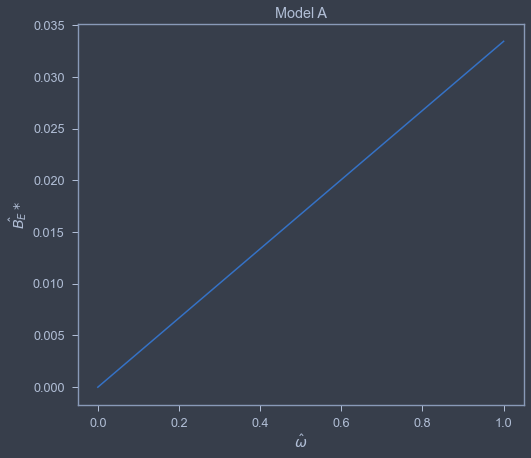

In [17]:
fig,ax=plt.subplots()
ax.plot(w_hats, B_E0_star_hat[0])
ax.set_title('Model A')
ax.set_xlabel(r'$\hat{\omega}$')
ax.set_ylabel(r'$\hat{B_E}*$')

In [18]:
def calculate_lewis(row):
    B_s = row.B
    T_s = row.d
    S_s = sigma*B_s*T_s
    return ikeda_speed.calculate_sectional_lewis(B_s=B_s, T_s=T_s, S_s=S_s)

def calculate_B_star_hat(parameters, g=9.81, rho=1000, **kwargs):
    
    a, a_1, a_3, sigma_s, H = calculate_lewis(parameters)
    
    OG=parameters['OG/d']*parameters.d
    R = parameters.R 
        
    w = lambdas.omega_from_hat(beam=parameters.B, g=g, omega_hat=parameters.w_hat)
    B_E0_s = eddy_sections(bwl=B_s, a_1=a_1, a_3=a_3, sigma=sigma_s, H0=H, Ts=T_s,
             OG=OG, R=R, wE=w, fi_a=parameters.phi_a, ra=1000.0)
    B_E0 = B_E0_s*parameters.L
    
    Disp = parameters.volume
    B_E0_hat = lambdas.B_to_hat_lambda(B=B_E0, Disp=Disp, beam=B_s, g=g, rho=rho)
    B_E0_star_hat = B_E0_hat*3*np.pi/8
    
    return B_E0_star_hat[0][0]

In [19]:
df

,L,B,d,volume,H0,sigma,OG/d,R
No,,,,,,,,
A,0.8,0.280,0.112,0.02509,1.2500,1.000,0.000,0.00
B,0.8,0.280,0.112,0.02501,1.2500,0.997,0.000,0.01
C,0.8,0.280,0.112,0.02495,1.2500,0.995,0.000,0.02
D,0.8,0.280,0.112,0.02475,1.2500,0.988,0.000,0.03
E,0.8,0.024,0.070,0.00116,0.1710,0.866,-1.753,NaN
F,0.8,0.064,0.150,0.00763,0.2100,0.992,-0.800,NaN
G,0.8,0.185,0.192,0.02321,0.4850,0.799,0.000,NaN
H,0.8,0.398,0.193,0.05490,1.0360,0.893,0.000,NaN
I,0.8,0.237,0.096,0.01775,1.2320,0.977,0.000,NaN


In [28]:
df_paper_data = pd.merge(left=df_paper, right=df, how='left', left_on='model', right_index=True)
df_paper_data

,phi_a,B_star_hat,w_hat,model,B_W+B_F,B_e_star_hat,L,B,d,volume,H0,sigma,OG/d,R
0,0.00,0.003636,0.751,A,0.003636,0.000000,0.8,0.28,0.112,0.02509,1.25,1.000,0.0,0.00
1,0.23,0.041169,0.751,A,0.003636,0.037534,0.8,0.28,0.112,0.02509,1.25,1.000,0.0,0.00
0,-0.00,0.001391,0.507,A,0.001391,0.000000,0.8,0.28,0.112,0.02509,1.25,1.000,0.0,0.00
1,0.24,0.029803,0.507,A,0.001391,0.028413,0.8,0.28,0.112,0.02509,1.25,1.000,0.0,0.00
0,-0.00,0.003265,0.751,B,0.003265,0.000000,0.8,0.28,0.112,0.02501,1.25,0.997,0.0,0.01
1,0.30,0.023966,0.751,B,0.003265,0.020700,0.8,0.28,0.112,0.02501,1.25,0.997,0.0,0.01
0,-0.00,0.001111,0.536,B,0.001111,0.000000,0.8,0.28,0.112,0.02501,1.25,0.997,0.0,0.01
1,0.30,0.014438,0.536,B,0.001111,0.013328,0.8,0.28,0.112,0.02501,1.25,0.997,0.0,0.01
0,0.00,0.002115,0.751,C,0.002115,0.000000,0.8,0.28,0.112,0.02495,1.25,0.995,0.0,0.02
1,0.27,0.008265,0.751,C,0.002115,0.006151,0.8,0.28,0.112,0.02495,1.25,0.995,0.0,0.02


In [29]:
df_paper_data['B_e_star_hat_pred'] = df_paper_data.apply(func=calculate_B_star_hat, axis=1)

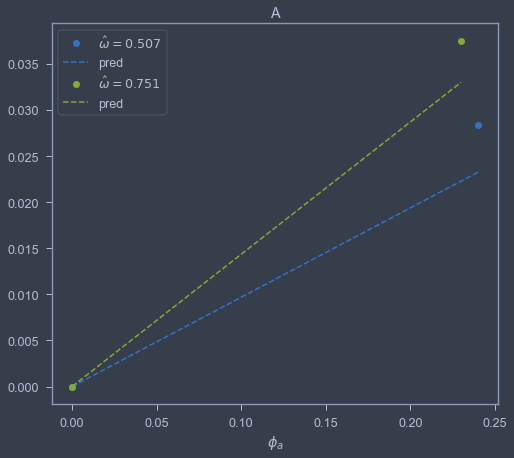

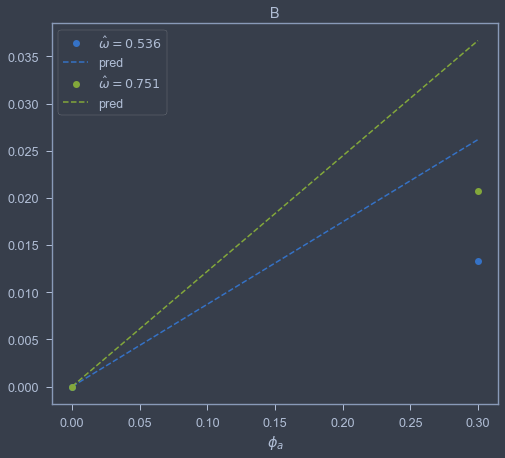

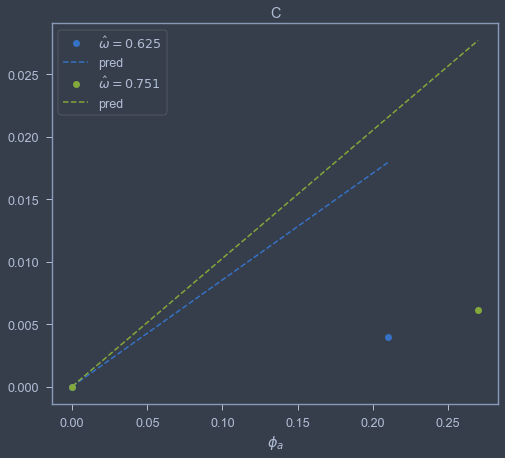

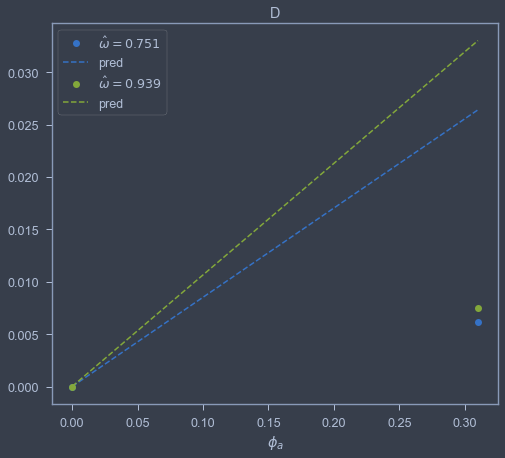

In [30]:
for model_name, model_data in df_paper_data.groupby(by='model'):
    fig,ax=plt.subplots()
    for w_hat, df_ in model_data.groupby(by='w_hat'):
        label = '$\hat{\omega}=%0.3f$' % w_hat
        p = df_.plot(x='phi_a', y='B_e_star_hat', style='o', ax=ax, label=label)
        line = p.lines[-1]
        color = line.get_color()
        df_.plot(x='phi_a', y='B_e_star_hat_pred', style='--', ax=ax, color=color, label='pred')
        
    ax.set_xlabel('$\phi_a$')
    ax.set_title(model_name)